In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.svm import  LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer as tf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
from string import punctuation
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV




 # 1.Data Exploration

In [6]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', 
                 delimiter=',', encoding='ISO-8859-1')
df.columns = ['sentiment','id','date','query','user','text']

# 2.Data Preprocessing

In [7]:
stuff_to_be_removed = list(punctuation)





def textprocessing(text):
    text = str(text)
    text = text.lower()                                                          # converting all uppercase letters to lowercase
    text = re.sub(r"https\S+|www\S+|https\S+"," ",text,flags=re.MULTILINE)       # removing all links from dataset
    text=re.sub("(\\d|\\W)+"," ",text)       
    text = re.sub(r'\@\w+|\#'," ",text)                                          # removing # and @ symbols from dataset
    text = re.sub(r'[^\w\s\`]'," ",text)                                         # removing other symbols like ^ except '
    text_tokens = word_tokenize(text) 
    lem = SnowballStemmer("english")
    text = [lem.stem(word) for word in text_tokens if not word in stuff_to_be_removed] 
    text1 = " ".join(text)
    
    return text1 

In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

data_cleaned = pd.DataFrame()
df['text'] = df['text'].apply(textprocessing)
df['text'].head()

In [9]:
negative_text = ' '.join(df[df['sentiment'] == 0]['text'])
positive_text = ' '.join(df[df['sentiment'] == 1]['text'])
df = df[['sentiment','text']]
df.head()

,sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


# 3.Exploratory data analysis(EDA)



In [10]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1048572 non-null  int64 
 1   text       1048572 non-null  object
dtypes: int64(1), object(1)
memory usage: 16.0+ MB


In [11]:
df.describe()

,sentiment
count,1.048572e+06
mean,9.482458e-01
std,1.701122e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,4.000000e+00


In [12]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [13]:
df['sentiment'] = df['sentiment'].replace({4:1})

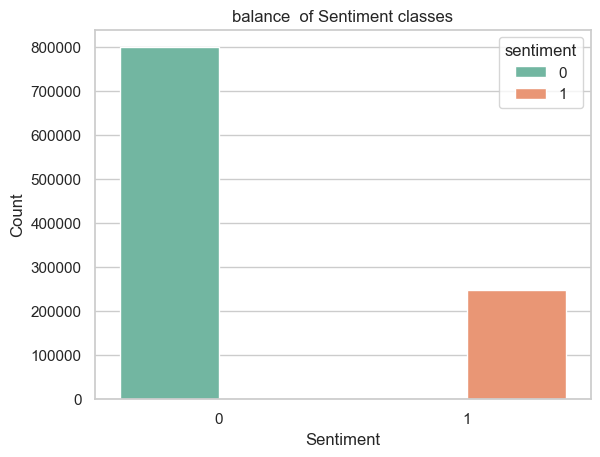

In [14]:
sns.set(style="whitegrid") 

sns.countplot(data=df, x='sentiment', hue='sentiment', palette='Set2')

# Customize plot labels and title if needed
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('balance  of Sentiment classes')

# Show the plot
plt.show()

In [15]:
df['text'].isnull().sum()

0

In [16]:
df = df.drop_duplicates('text')

# 4 Text Vectorization:

In [17]:
x = df['text']
y = df['sentiment']

vectorizer = tf()
vectors = vectorizer.fit_transform(x)

In [18]:
X_train_svm, X_temp_svm, y_train_svm, y_temp_svm = train_test_split(vectors, y, test_size=0.3, random_state=52)

X_validation_svm, X_test_svm, y_validation_svm, y_test_svm = train_test_split(X_temp_svm, y_temp_svm, test_size=0.5, random_state=52)

# 5.Model Selection

In [19]:
n_components = 100  
svd = TruncatedSVD(n_components=n_components)
X_train_svm_pca = svd.fit_transform(X_train_svm)
X_validation_svm_pca = svd.transform(X_validation_svm)
X_test_svm_pca = svd.transform(X_test_svm)

In [20]:
svm_model = LinearSVC(dual = True)
svm_model.fit(X_train_svm_pca, y_train_svm)


y_pred_validation_svm = svm_model.predict(X_validation_svm_pca)
accuracy_validation_svm = accuracy_score(y_validation_svm, y_pred_validation_svm)
print(f"Accuracy on the validation set: {accuracy_validation_svm}")


y_pred_test_svm = svm_model.predict(X_test_svm_pca)
accuracy_test_svm = accuracy_score(y_test_svm, y_pred_test_svm)
print(f"Accuracy on the test set: {accuracy_test_svm}")

Accuracy on the validation set: 0.78717668253764
Accuracy on the test set: 0.7881160725775318


In [21]:
classifier = CalibratedClassifierCV(LinearSVC(dual = True), method='sigmoid')
classifier.fit(X_train_svm, y_train_svm)

CalibratedClassifierCV(base_estimator=LinearSVC())

In [22]:
svm_predictions_train = classifier.predict(X_train_svm)

accuracy = accuracy_score(y_train_svm, svm_predictions_train)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_train_svm, svm_predictions_train))


Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95    553132
           1       0.91      0.74      0.82    172160

    accuracy                           0.92    725292
   macro avg       0.92      0.86      0.89    725292
weighted avg       0.92      0.92      0.92    725292



In [23]:
svm_prediction_test = classifier.predict(X_test_svm)


accuracy = accuracy_score(y_test_svm, svm_prediction_test)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_test_svm, svm_prediction_test))

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91    118493
           1       0.75      0.55      0.63     36927

    accuracy                           0.85    155420
   macro avg       0.81      0.75      0.77    155420
weighted avg       0.84      0.85      0.84    155420



In [24]:
svm_predictions_validation= classifier.predict(X_validation_svm)

accuracy = accuracy_score(y_validation_svm, svm_predictions_validation)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_validation_svm, svm_predictions_validation))

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91    118556
           1       0.75      0.54      0.63     36864

    accuracy                           0.85    155420
   macro avg       0.81      0.74      0.77    155420
weighted avg       0.84      0.85      0.84    155420



In [25]:
X = df['text']
y = df['sentiment']

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer()
Xt = tfid.fit_transform(X)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state= 42)

In [28]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\gangu\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [29]:
y_pred = model.predict(X_test)

In [30]:
#Showing Model Summary
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print('Classification Report:\n', classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91    158145
           1       0.76      0.56      0.64     49082

    accuracy                           0.85    207227
   macro avg       0.82      0.75      0.77    207227
weighted avg       0.85      0.85      0.84    207227



In [32]:
## majority class 0
df_majority_knn = df[df['sentiment']==0]
## minority class 1
df_minority_knn = df[df['sentiment']==1]

df_majority_downsampled_knn = resample(df_majority_knn, 
                                 replace=False,   
                                 n_samples=len(df_minority_knn)//5,    
                                 random_state=134)

df_minority_downsampled_knn = resample(df_minority_knn, 
                                 replace=False,   
                                 n_samples=len(df_minority_knn)//5,    
                                 random_state=134)

In [33]:
#text vectorization
df = pd.concat([df_majority_downsampled_knn, df_minority_downsampled_knn])

x = df['text']
y = df['sentiment']


vectorizer2 = tf()
vectors = vectorizer2.fit_transform(x)

vectors.shape

(98380, 96042)

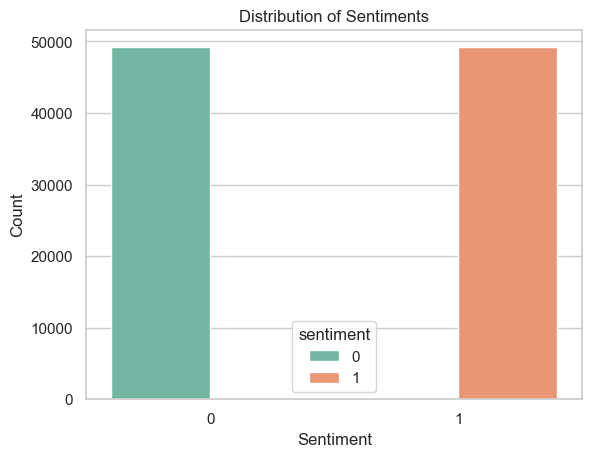

In [36]:
sns.set(style="whitegrid") 

sns.countplot(data=df, x='sentiment', hue='sentiment', palette='Set2')

# Customize plot labels and title if needed
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Show the plot
plt.show()

In [ ]:
X_train_knn, X_temp_knn, y_train_knn, y_temp_knn = train_test_split(vectors, y, test_size=0.3, random_state=52)

X_validation_knn, X_test_knn, y_validation_knn, y_test_knn = train_test_split(X_temp_knn, y_temp_knn, test_size=0.5, random_state=52)

In [ ]:
# for KNN
n_components = 100  
svd = TruncatedSVD(n_components=n_components)
X_train_knn_pca = svd.fit_transform(X_train_knn)
X_validation_knn_pca = svd.transform(X_validation_knn)
X_test_knn_pca = svd.transform(X_test_knn)


knn_model = KNeighborsClassifier(n_neighbors=5) 
knn_model.fit(X_train_knn_pca, y_train_knn)


y_pred_validation_knn = knn_model.predict(X_validation_knn_pca)
accuracy_validation_knn = accuracy_score(y_validation_knn, y_pred_validation_knn)
print(f"Accuracy on the validation set: {accuracy_validation_knn}")

y_pred_test_knn = knn_model.predict(X_test_knn_pca)
accuracy_test_knn = accuracy_score(y_test_knn, y_pred_test_knn)
print(f"Accuracy on the test set: {accuracy_test_knn}")

In [62]:
l = int(np.sqrt(len(x)))
print(l)

313


In [59]:
knn_classifier = KNeighborsClassifier(n_neighbors=l)  # You can experiment with different values of k
knn_classifier.fit(X_train_knn, y_train_knn)
knn_predictions_train =knn_classifier.predict(X_train_knn) 
knn_accuracy = accuracy_score(y_train_knn, knn_predictions_train)
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:")
print(classification_report(y_train_knn, knn_predictions_train))

KNN Accuracy: 0.74
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.85      0.77     34502
           1       0.81      0.62      0.70     34364

    accuracy                           0.74     68866
   macro avg       0.75      0.74      0.74     68866
weighted avg       0.75      0.74      0.74     68866



In [ ]:
knn_prediction_test = knn_classifier.predict(X_test_knn) 
knn_accuracy = accuracy_score(y_test_knn, knn_prediction_test)
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:")
print(classification_report(y_test_knn, knn_prediction_test))

In [ ]:
knn_predictions_validation =knn_classifier.predict(X_validation_knn) 
knn_accuracy = accuracy_score(y_validation_knn, knn_predictions_validation)
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:")

print(classification_report(y_validation_knn, knn_predictions_validation))

In [ ]:
knn_predictions_validation =knn_classifier.predict(X_validation_knn) 
knn_accuracy = accuracy_score(y_validation_knn, knn_predictions_validation)
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:")

print(classification_report(y_validation_knn, knn_predictions_validation))

In [ ]:
def metrics(y_train, y_train_pred, y_test, y_test_pred):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm_train = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=None)
    disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
    axes[0].set_title('Training Confusion Matrix ')

    
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=None)
    disp_test.plot(ax=axes[1], cmap='Blues', values_format='d')
    axes[1].set_title('Testing Confusion Matrix')

    plt.show()

# ROC AUC

In [ ]:
def plot_roc_curve(fpr, tpr, label, title):
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(label, auc(fpr, tpr)))


plt.figure(figsize=(10, 6))

# KNN
knn_probs = knn_classifier.predict_proba(X_test_knn)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y_test_knn, knn_probs)
plot_roc_curve(knn_fpr, knn_tpr, 'KNN', 'ROC Curve - KNN')

# SVM
svm_probs = classifier.predict_proba(X_test_svm)[:, 1]
svm_fpr, svm_tpr, _ = roc_curve(y_test_svm, svm_probs)
plot_roc_curve(svm_fpr, svm_tpr, 'SVM', 'ROC Curve - SVM')

# Plotting diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()